# Recurrent Neural Networks with TensorFlow
Based on Chap. 14 of `Hands-On Machine Learning with Scikit-Learn and TensorFlow` by A. Géron. 

### Introduction
Recurrent neural networks (RNNs) are used for time series data, where not only the present but also the past matters. In other words, RNNs differ from feed-forward networks in that they can remember state. At each time step $t$, a recurrent neuron receives the input $\mathbf{x}_t$ at time $t$ as well as its own output from the previous time step, $y_{(t-1)}$. Similarly, a layer of recurrent neurons receives not only the input $\mathbf{x}_t$ but also the output $\mathbf{y}_{(t-1)}$ of the whole layer from the previous time step.

Each recurrent neuron has two sets of weights, one for the inputs and the other for the outputs of the previous time step. The output of a recurrent layer for a single instance $\mathbf{x}_{(t)}$ is 

$$
 \mathbf{y}_{(t)} = \phi ( \mathbf{W}_x^T \cdot \mathbf{x}_{(t)} + \mathbf{W}_y^T \cdot \mathbf{y}_{(t-1)} + \mathbf{b}),
$$

where the $\phi$ is the activation function and the weights and bias are similar as for feed-forward networks.

A part of a neural network that remembers state is called a _memory cell_. Examples include a layer of recurrent neurons, long short-term memory cell (LSTM) and gated recurrent unit (GRU).

In general, a cell's state $\mathbf{h}_{(t)}$ at time step $t$ is a function of the inputs at that timestep and the state at the previous time step: $\mathbf{h}_{(t)} = f(\mathbf{h}_{(t-1)}, \mathbf{x}_{(t)})$. Similarly, the output is a function of the inputs and the previous state.

RNNs take a sequence as input and produce a sequence as output. This is called a sequence-to-sequence network. Ignoring all outputs but the last creates a sequence-to-vector network. Similarly, one can feed a non-zero value to RNN at the first time step and zeroes afterwards, creating a vector-to-sequence (or vector-to-vector by ignoring all outputs except for one) network. One can also have a sequence-to-vector network, called an encoder, followed by a vector-to-sequence network, called a decoder. This could be used for translating a sentence from a language to another. This works better than a single sequence-to-sequence RNN, because the last words of a sentence can affect the first words of the translation. 

As practice, let us create an RNN in TensorFlow from scratch.

In [1]:
import tensorflow as tf
import numpy as np

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/Users/ksaaskil/.pyenv/versions/3.5.0/envs/python3.5.0/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n_inputs = 3
n_neurons = 5

reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs]) # Input at time 0
X1 = tf.placeholder(tf.float32, [None, n_inputs]) # Input at time 1

Wx = tf.Variable(tf.random_normal(shape=(n_inputs, n_neurons)), dtype=tf.float32)
Wy = tf.Variable(tf.random_normal(shape=(n_neurons, n_neurons)), dtype=tf.float32)

b = tf.Variable(tf.random_normal(shape=(1, n_neurons)), dtype = tf.float32)

Y0 = tf.tanh(tf.matmul(X0, Wx) + b) # Output at time 0
Y1 = tf.tanh(tf.matmul(X1, Wx) + tf.matmul(Y0, Wy) + b)

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # Values at time step 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [0, 0, 0], [3, 2, 1]]) # Values at time step 1

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={ X0: X0_batch, X1: X1_batch })
    
print(Y1_val)

[[ 1.         -0.9999999  -1.          0.38309905 -0.9999999 ]
 [ 0.07339995  0.9980602   0.96289444 -0.9989617   0.83170354]
 [ 0.37173954  0.87310225  0.9678148  -0.9957409   0.05245034]
 [ 0.9997043  -0.9999829  -0.9999097   0.9722856  -0.7746241 ]]


Now let use built-in functions from TensorFlow:

In [3]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs]) # Input at time 0
X1 = tf.placeholder(tf.float32, [None, n_inputs]) # Input at time 1

# A "factory" that creates copies of the cell to build the unrolled RNN
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

# `static_rnn` calls the cell factory's `__call__()` once per input, creating two copies of the cell, 
# with shared weights and bias terms, and chains them together
# The first output is a list containing the output tensors at each timestep,
# the second is a tensor containing the final states of the network (last output for basic RNN cell).
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)

Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={ X0: X0_batch, X1: X1_batch })

print(Y1_val)

[[ 0.99998885 -0.99976057 -0.0667929  -0.9999803   0.99982214]
 [-0.6524943  -0.51520866 -0.37968948 -0.5922594  -0.08968379]
 [-0.68117034 -0.49779245 -0.40294588 -0.6201728  -0.12251603]
 [ 0.99681675 -0.9598194   0.39660627 -0.8307606   0.79671973]]


The above approach would not work very well if there were 50 time steps in input sequences. Let's do it differently:

In [4]:
reset_graph()
n_steps = 2

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # Input sequences, replaces X0 and X1 above

X_rearr = tf.transpose(X, perm=[1, 0, 2]) # To format [n_steps, None, n_inputs]
X_seqs = tf.unstack(X_rearr) # Sequence of tensors of shape [None, n_inputs] (corresponds to [X0, X1] above)

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

# In `output_seqs`, each tensor (corresponding to different timestep) is of size [None, n_outputs]
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)

outputs_stacked = tf.stack(output_seqs) # Merge output tensors into a single tensor, [n_steps, None, n_outputs]
outputs = tf.transpose(outputs_stacked, perm=[1, 0, 2]) # To format [None, n_steps, n_outputs]

X_batch = np.array([
    [[0, 1, 2], [3, 4, 5]], # First instance
    [[3, 4, 5], [5, 6, 7]], # Second instance
    [[5, 6, 7], [7, 8, 9]], # Third
    [[7, 8, 9], [9, 10, 11]] # Fourth
])

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.91160655 -0.99046797  0.88150513  0.9981036  -0.99842864]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.97830385 -0.999259    0.971717    0.9999602  -0.9999778 ]]

 [[-0.9057112  -0.99940944  0.8976473   0.9998999  -0.9998998 ]
  [-0.99159604 -0.9999457   0.9873541   0.99999887 -0.99999934]]

 [[-0.95685035 -0.9999554   0.95359534  0.99999654 -0.99999726]
  [-0.99649936 -0.99999607  0.9943718   1.         -1.        ]]]


Static RNN used above would still get very ugly for large input sequences, as it still essentially creates one cell per timestep (the weights and bias terms are shared, though). To avoid this, one can use _dynamic unrolling_ that uses a `while_loop()` to run over the cell as many times as needed. It also accepts an input of shape `[None, n_steps, n_inputs]` and outputs a tensor of shape `[None, n_steps, n_outputs]`, so there is no need to unstack, transpose, and stack as above. The following code does the same as above:

In [5]:
reset_graph()
n_steps = 2

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # Input sequences, replaces X0 and X1 above

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

# `outputs` is of size [None, n_steps, n_inputs], states is equal to the `outputs` at last time step
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

X_batch = np.array([
    [[0, 1, 2], [3, 4, 5]], # First instance
    [[3, 4, 5], [5, 6, 7]], # Second instance
    [[5, 6, 7], [7, 8, 9]], # Third
    [[7, 8, 9], [9, 10, 11]] # Fourth
])

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    outputs_val, states = sess.run([outputs, states], feed_dict={X: X_batch})
    
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.99975723  0.99944186  0.90882957  0.9999934  -0.32912886]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.99998647  0.9999697   0.9734116   1.         -0.53655857]]

 [[-0.9999203   0.99997395  0.9978532   1.          0.43522152]
  [-0.9999992   0.99999887  0.99618906  1.         -0.4498868 ]]

 [[-0.9999963   0.9999993   0.9997629   1.          0.58837163]
  [-1.          1.          0.99948734  1.         -0.33206707]]]


Variable-length input sequences can be handled by passing `sequence_length` argument to `dynamic_rnn`, containing a list of sequence length for each instance in the mini-batch. The RNN outputs zero vectors for every time step past the input sequence length. Variable-length output sequences (like in text translation) are generally handled by a special output called an _end-of-sequence token_ (EOS). Any output past EOS should be ignored.

### Training RNNs

RNNs are trained using _backpropagation through time_. Gradients are propagated backward through the unrolled network and finally the parameters are updated using the gradients computed during backpropagation.

As a toy example of training RNNs, let us use an RNN to classify MNIST images. A row in input image corresponds to a single time step. For MNIST images, there are then 28 timesteps with 28 inputs each.

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
reset_graph()

n_steps = 28
n_inputs = 28

n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs))
y = tf.placeholder(tf.int32, shape=(None))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

mnist = input_data.read_data_sets("/tmp/mnist/data")

X_valid = mnist.validation.images.reshape((-1, n_steps, n_inputs))
y_valid = mnist.validation.labels

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs + 1):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            loss_train, acc_train, _ = sess.run([loss, accuracy, training_op], feed_dict={X: X_batch, y: y_batch})

        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid, y: y_valid})
        print("{}\tTraining loss: {:.6f}\tTraining acc: {:.6f}\tValidation loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train, loss_val, acc_val * 100))
        

        

Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz
1	Training loss: 0.275220	Training acc: 0.913333	Validation loss: 0.244868	Accuracy: 93.10%
2	Training loss: 0.124366	Training acc: 0.966667	Validation loss: 0.164343	Accuracy: 95.58%
3	Training loss: 0.246158	Training acc: 0.926667	Validation loss: 0.146260	Accuracy: 96.04%
4	Training loss: 0.161353	Training acc: 0.953333	Validation loss: 0.129532	Accuracy: 96.38%
5	Training loss: 0.150708	Training acc: 0.966667	Validation loss: 0.137861	Accuracy: 96.18%
6	Training loss: 0.116905	Training acc: 0.953333	Validation loss: 0.107175	Accuracy: 96.98%
7	Training loss: 0.099635	Training acc: 0.966667	Validation loss: 0.095419	Accuracy: 97.50%
8	Training loss: 0.165225	Training acc: 0.946667	Validation loss: 0.102198	Accuracy: 97.02%
9	Training loss: 0.174324	Training acc: 0.960000	V

### Predicting time series

In [7]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Create fake time series. RNN is trained to predict the time series shifted five time steps to the future.

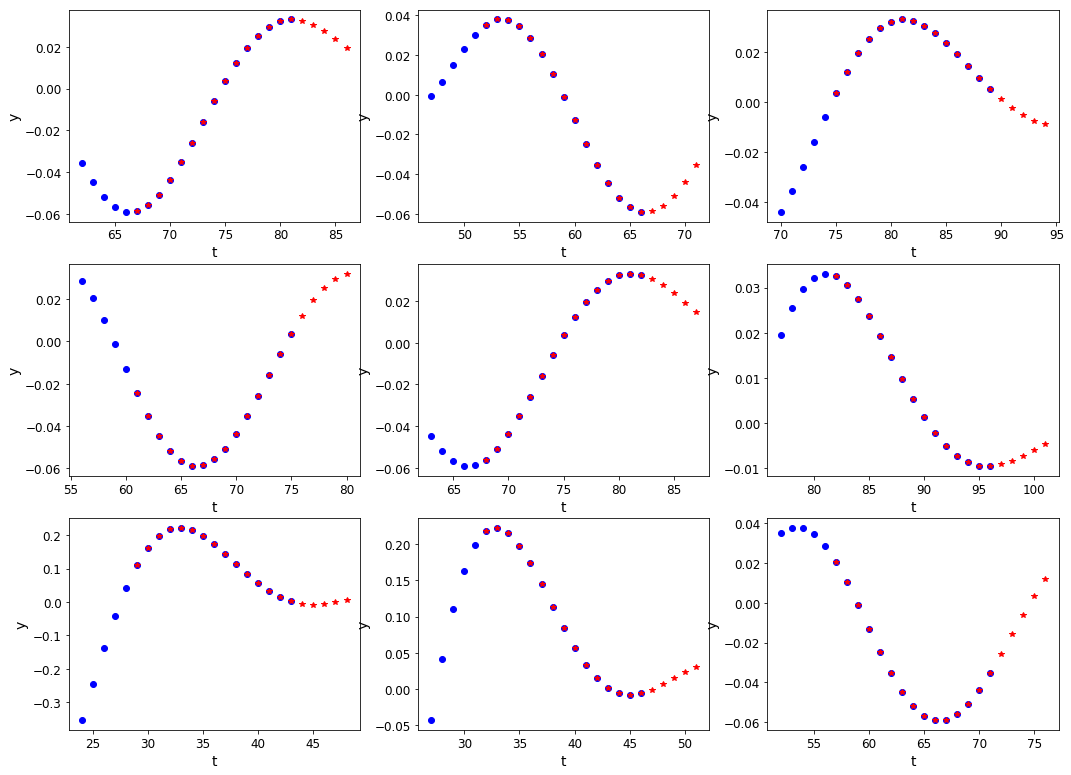

In [9]:
import math

def time_series_func(t):
    return np.exp(-t)*(np.sin(5*t) + np.cos(3*t))

def time_series(n_steps=20, batch_size=50):
    MAX_T = 100
    STEP = 0.05
    
    t_shift = 5
    
    STEPS_PER_INSTANCE = n_steps + t_shift # Need to have space for shifting targets to the future
    
    N_SAMPLES = math.floor(MAX_T / STEP / STEPS_PER_INSTANCE)
    
    start_indices = np.arange(N_SAMPLES) * STEPS_PER_INSTANCE

    n_batches = N_SAMPLES // batch_size
    
    batch_indices = np.random.permutation(n_batches)
    
    permuted_indices = np.random.permutation(N_SAMPLES)

    X = time_series_func(np.arange(0, MAX_T, STEP))
 
    for i in range(n_batches):
        indices = permuted_indices[i*batch_size : (i+1) * batch_size]
        X_batch = []
        y_batch = []
        Xt_batch = []
        yt_batch = []
        for ind in indices:
            x_ts = np.arange(ind, ind + n_steps)
            y_ts = x_ts + t_shift
            X_batch.append(X[x_ts])
            y_batch.append(X[y_ts])
            Xt_batch.append(x_ts)
            yt_batch.append(y_ts)
        yield Xt_batch, yt_batch, np.array(X_batch), np.array(y_batch)
    

batch_size = 50
batches = [(Xt_batch, yt_batch, X_batch, y_batch) 
           for Xt_batch, yt_batch, X_batch, y_batch in time_series(n_steps=20, batch_size=batch_size)]

Xt_batch, yt_batch, X_batch, y_batch = batches[0]

assert len(X_batch) == batch_size

f, axarr = plt.subplots(3, 3, figsize=(11, 8))

assert len(Xt_batch) > len(np.ravel(axarr))
assert X_batch.shape == (batch_size, 20)

for i, ax in enumerate(np.ravel(axarr)):
    Xt, Yt, X, y = Xt_batch[i], yt_batch[i], X_batch[i], y_batch[i]
    ax.plot(Xt, X, 'bo', label='X')
    ax.plot(Yt, y, 'r*', label='y')
    ax.set_xlabel('t')
    ax.set_ylabel('y')
    
plt.subplots_adjust(bottom=0.25, left=0.25, right=1.5, top=1.5)
plt.show()

In [26]:
reset_graph()
n_steps = 20
n_inputs = 1

n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)

# Without the wrapper, RNN would output a vector of size 100 at each time step. We want a vector of size one.
wrapped_cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(wrapped_cell, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 50

batch_size = 50

with tf.Session() as sess:
    init.run()
    
    for epoch in range(1, n_epochs + 1):
        for Xt_batch, yt_batch, X_batch, y_batch in time_series(batch_size=batch_size, n_steps=20):
            X_batch = np.expand_dims(X_batch, axis=2)
            y_batch = np.expand_dims(y_batch, axis=2)
            mse, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y:y_batch})
        if epoch % 5 == 0:
            print(epoch, "\tMSE:", mse)
    # For visualizing below
    prediction = sess.run(outputs, feed_dict={X: X_batch})
    saver.save(sess, './tf-logs/chap-14-predict-rnn')

5 	MSE: 0.045530815
10 	MSE: 0.018924482
15 	MSE: 0.016629713
20 	MSE: 0.020387543
25 	MSE: 0.01702493
30 	MSE: 0.01555638
35 	MSE: 0.014535023
40 	MSE: 0.014140413
45 	MSE: 0.01216564
50 	MSE: 0.008781117


Now check predictions for the last `X_batch`:

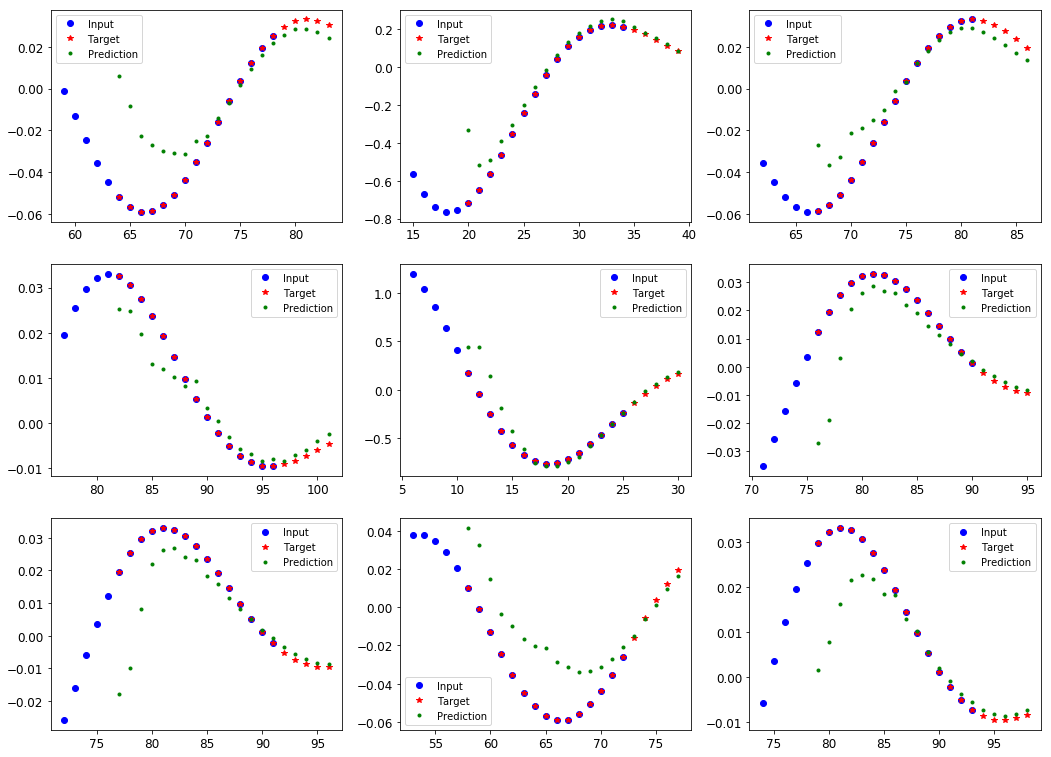

In [27]:
assert len(X_batch) == batch_size

f, axarr = plt.subplots(3, 3, figsize=(11, 8))

for i, ax in enumerate(np.ravel(axarr)):
    Xt, Yt, Xs, ys, zs = Xt_batch[i], yt_batch[i], X_batch[i], y_batch[i], prediction[i]
    ax.plot(Xt, Xs, 'bo', label='Input')
    ax.plot(Yt, ys, 'r*', label='Target')
    ax.plot(Yt, zs, 'g.', label='Prediction')
    ax.legend()

plt.subplots_adjust(bottom=0.25, left=0.25, right=1.5, top=1.5)
plt.show()

Create a new sequence by starting from ones and appending at each iteration the last value of the predicted sequence:

INFO:tensorflow:Restoring parameters from ./tf-logs/chap-14-predict-rnn


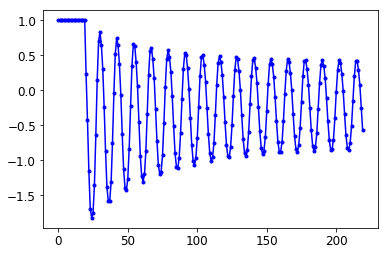

In [33]:
sequence = [1.] * n_steps

with tf.Session() as sess:
    saver.restore(sess, './tf-logs/chap-14-predict-rnn')

    for i in range(200):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1).astype(np.float32)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])
        
plt.plot(sequence, 'b.-')
plt.show()

Deep RNNs can be created using `MultiRNNCell` as follows:


In [38]:
reset_graph()
n_steps = 20
n_inputs = 1
n_layers = 3

n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

basic_cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]
basic_cells[-1] = tf.contrib.rnn.OutputProjectionWrapper(basic_cells[-1], output_size=n_outputs)

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(basic_cells)

outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 100

batch_size = 50

with tf.Session() as sess:
    init.run()
    
    for epoch in range(1, n_epochs + 1):
        for Xt_batch, yt_batch, X_batch, y_batch in time_series(batch_size=batch_size, n_steps=20):
            X_batch = np.expand_dims(X_batch, axis=2)
            y_batch = np.expand_dims(y_batch, axis=2)
            mse, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y:y_batch})
        if epoch % 5 == 0:
            print(epoch, "\tMSE:", mse)
    # For visualizing below
    prediction = sess.run(outputs, feed_dict={X: X_batch})
    saver.save(sess, './tf-logs/chap-14-predict-multi-rnn')

5 	MSE: 0.046113648
10 	MSE: 0.014935477
15 	MSE: 0.014451682
20 	MSE: 0.01628125
25 	MSE: 0.0131466715
30 	MSE: 0.011594045
35 	MSE: 0.010465951
40 	MSE: 0.009717026
45 	MSE: 0.008118143
50 	MSE: 0.0056361672
55 	MSE: 0.006756349
60 	MSE: 0.008208474
65 	MSE: 0.007312002
70 	MSE: 0.008106523
75 	MSE: 0.0052140374
80 	MSE: 0.0068333303
85 	MSE: 0.0061269547
90 	MSE: 0.0049820766
95 	MSE: 0.005197421
100 	MSE: 0.0050283144


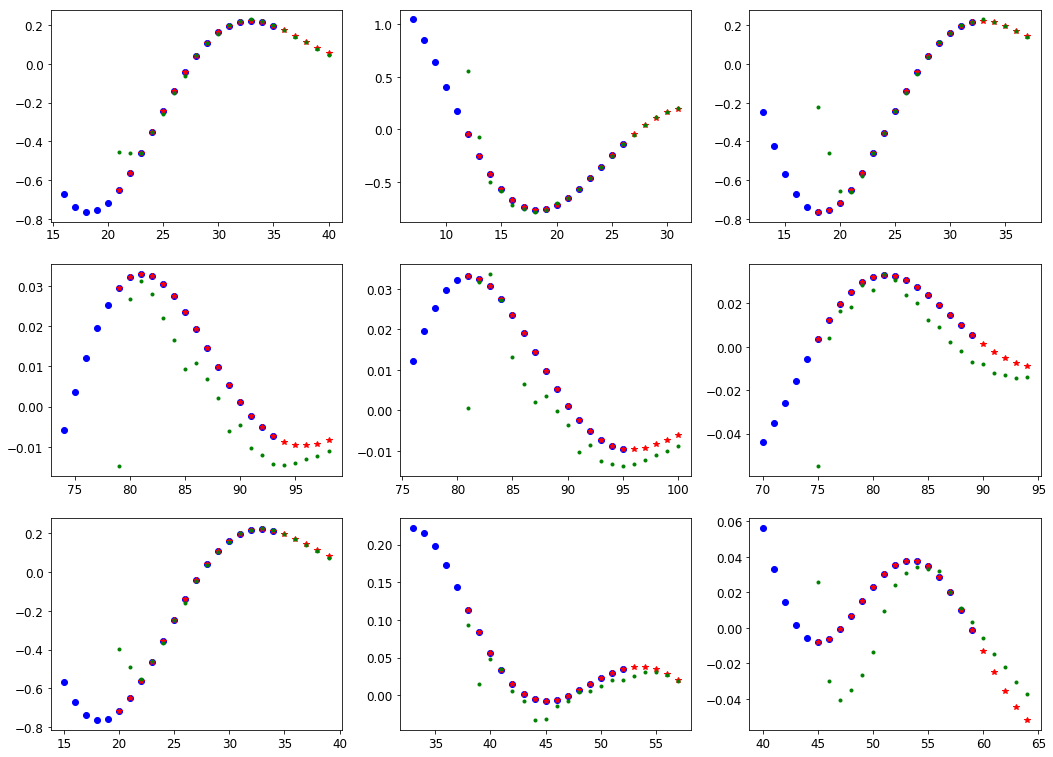

In [39]:
f, axarr = plt.subplots(3, 3, figsize=(11, 8))

for i, ax in enumerate(np.ravel(axarr)):
    Xt, Yt, Xs, ys, zs = Xt_batch[i], yt_batch[i], X_batch[i], y_batch[i], prediction[i]
    ax.plot(Xt, Xs, 'bo', label='X')
    ax.plot(Yt, ys, 'r*', label='y')
    ax.plot(Yt, zs, 'g.', label='Prediction')

plt.subplots_adjust(bottom=0.25, left=0.25, right=1.5, top=1.5)
plt.show()

Creating new sequences with the multi-layer RNN generates exploding sequences:

INFO:tensorflow:Restoring parameters from ./tf-logs/chap-14-predict-multi-rnn


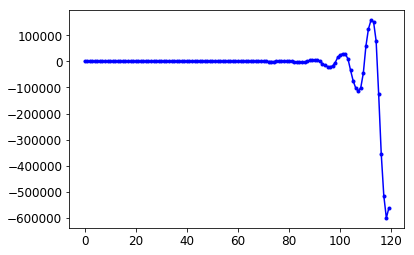

In [44]:
sequence = [0.] * n_steps

with tf.Session() as sess:
    saver.restore(sess, './tf-logs/chap-14-predict-multi-rnn')

    for i in range(100):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1).astype(np.float32)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])
        
plt.plot(sequence, 'b.-')
plt.show()

To avoid overfitting in multilayer RNNs, one may want to regularize the network using, e.g., dropout. Dropout can be applied to the inputs of each layer by using `DropoutWrapper`. It is also possible to apply dropout to the outputs using `output_keep_prob` and even to the cell's state using `state_keep_prob`. In addition, many tricks used to efficiently train feed-forward networks can be used for RNNs as well, like good parameter initialization, nonsaturating activation functions, Batch Normalization, Gradient Clipping, and faster optimizers.

However, basic RNNs still suffer from the fact that the memories from the first inputs gradually fades away (the cells do not have long-term memory). Basic cells have therefore been mostly replaced by more advanced cells such as LSTM and GRU.

### LSTM and GRU cells

To do.